# Convolutional Neural Networks

In this notebook I'd like to check the effect of weight initialization on a given problem. I will use the fake news dataset and the features extracted in that project using TF-IDF. The architecture of convolutional neural network is the one that gave the best performance for the fake news dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Add, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from keras import initializers

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.

***

**Utility Functions**

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [4]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [5]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [6]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [7]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [8]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [9]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [10]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [11]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [12]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


**Define the model and metrics**



In [13]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The generic architecture of the model I've decided to use having two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. 

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

Additionally, there are two options to vectorize the data in Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This can be done with the Keras Embeddings Layer, or by using the pretrained embeddings.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This can be done with TFIDF for example.

**Why Initialize Weights**

The aim of weight initialization is to prevent layer activation outputs from exploding or vanishing during the course of a forward pass through a deep neural network. If either occurs, loss gradients will either be too large or too small to flow backwards beneficially, and the network will take longer to converge, if it is even able to do so at all.

**Choosing Weights: Small Changes, Big Differences**

There are a number of important, and sometimes subtle, choices that need to be made when building and training a neural network. We have to decide which loss function to use, how many layers to have, what stride and kernel size to use for each convolution layer, which optimization algorithm is best suited for the network, etc. With so many things that need to be decided, the choice of initial weights may, at first glance, seem like just another relatively minor pre-training detail, but weight initialization can actually have a profound impact on both the convergence rate and final quality of a network.

In order to illustrate this fact, I’ve trained the same neural network using three different weight initialization strategies.

In [14]:
x_train_tfidf = x_train_tfidf.todense()
x_test_tfidf = x_test_tfidf.todense()
x_val_tfidf = x_val_tfidf.todense()

In [15]:
x_train_tfidf = np.expand_dims(x_train_tfidf, axis = 2)
x_test_tfidf = np.expand_dims(x_test_tfidf, axis = 2)
x_val_tfidf = np.expand_dims(x_val_tfidf, axis = 2)

In [16]:
def make_model(filters = 16, kernel_size = 5, kernel_initializer='glorot_uniform'):
    
    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, kernel_initializer=kernel_initializer, activation='relu', input_shape=(x_train_tfidf.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())

    model.add(Dropout(0.1))

    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each of the 2 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = KERAS_METRICS)
    model.summary()
    return model

In [17]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [18]:
callbacks = [early_stopping]

In [19]:
BATCH_SIZE = 64
EPOCHS = 20

***
**All weights initially set to zero**
***

In [21]:
model = make_model(kernel_initializer=initializers.Zeros())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12498, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 99952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 99952)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [22]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
#                         callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1741s 2s/step - loss: 0.6930 - tp: 13483.8002 - fp: 12925.0643 - tn: 485.8949 - fn: 529.1332 - accuracy: 0.5078 - precision: 0.5006 - recall: 0.9063 - auc: 0.4973 - val_loss: 0.6929 - val_tp: 7000.0000 - val_fp: 6677.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5118 - val_precision: 0.5118 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/20
855/855 [==============================] - 1409s 2s/step - loss: 0.6929 - tp: 14030.8610 - fp: 13393.0315 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5109 - precision: 0.5109 - recall: 1.0000 - auc: 0.4969 - val_loss: 0.6929 - val_tp: 7000.0000 - val_fp: 6677.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5118 - val_precision: 0.5118 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
855/855 [==============================] - 1039s 1s/step - loss: 0.6928 - tp: 14073.0526 - fp: 13350.8400 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5143 - precision: 0.514

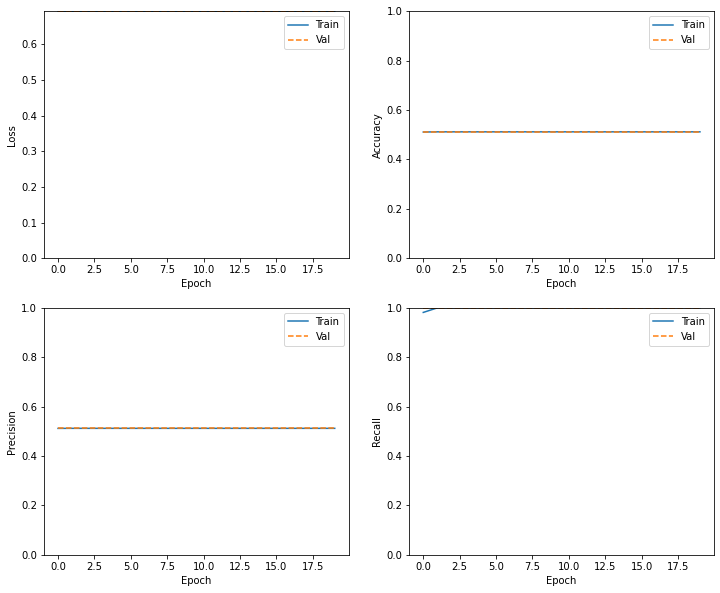

In [23]:
plot_metrics(history)

In [24]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [25]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  0
False Positives:  3710
False Negatives:  0
True Positives:  3889


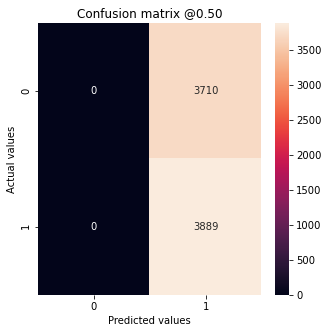

In [26]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [27]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3710
           1       0.51      1.00      0.68      3889

    accuracy                           0.51      7599
   macro avg       0.26      0.50      0.34      7599
weighted avg       0.26      0.51      0.35      7599



/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.35


In [29]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.50


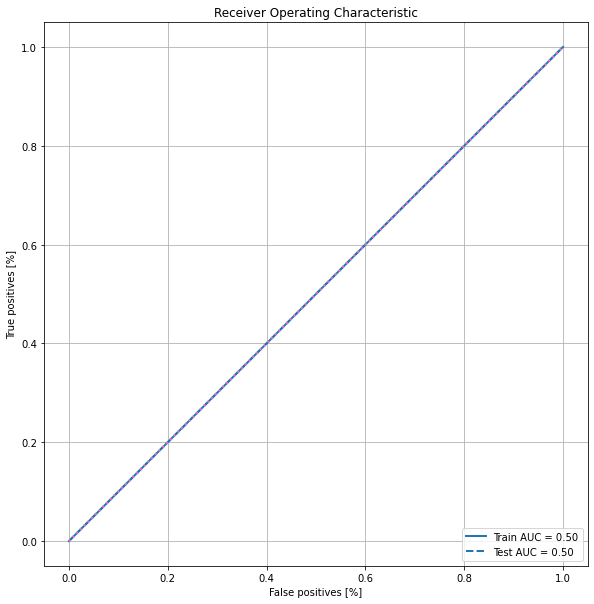

In [30]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**Weights drawn from a normal distribution with standard deviation**
***

In [31]:
model = make_model(kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.4, seed=10))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [32]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1441s 2s/step - loss: 0.5738 - tp: 17653.1425 - fp: 9959.1215 - tn: 10140.4825 - fn: 3348.1460 - accuracy: 0.6490 - precision: 0.6214 - recall: 0.8472 - auc: 0.7189 - val_loss: 0.2836 - val_tp: 6609.0000 - val_fp: 1211.0000 - val_tn: 5466.0000 - val_fn: 391.0000 - val_accuracy: 0.8829 - val_precision: 0.8451 - val_recall: 0.9441 - val_auc: 0.9587
Epoch 2/20
855/855 [==============================] - 3279s 4s/step - loss: 0.2342 - tp: 12718.6916 - fp: 1194.1297 - tn: 12250.6577 - fn: 1260.4136 - accuracy: 0.9078 - precision: 0.9107 - recall: 0.9075 - auc: 0.9663 - val_loss: 0.1999 - val_tp: 6426.0000 - val_fp: 477.0000 - val_tn: 6200.0000 - val_fn: 574.0000 - val_accuracy: 0.9232 - val_precision: 0.9309 - val_recall: 0.9180 - val_auc: 0.9753
Epoch 3/20
855/855 [==============================] - 1285s 2s/step - loss: 0.1726 - tp: 13202.8294 - fp: 871.4988 - tn: 12452.9720 - fn: 896.5923 - accuracy: 0.9350 - precision: 0.9376 - recall:

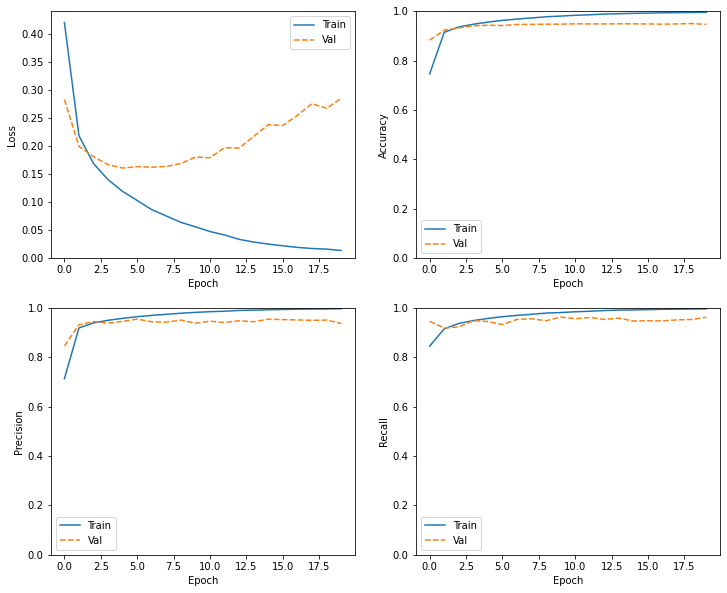

In [33]:
plot_metrics(history)

In [34]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [35]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3470
False Positives:  240
False Negatives:  140
True Positives:  3749


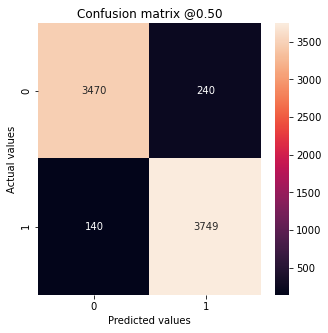

In [36]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [37]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3710
           1       0.94      0.96      0.95      3889

    accuracy                           0.95      7599
   macro avg       0.95      0.95      0.95      7599
weighted avg       0.95      0.95      0.95      7599



In [38]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.95


In [39]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.99


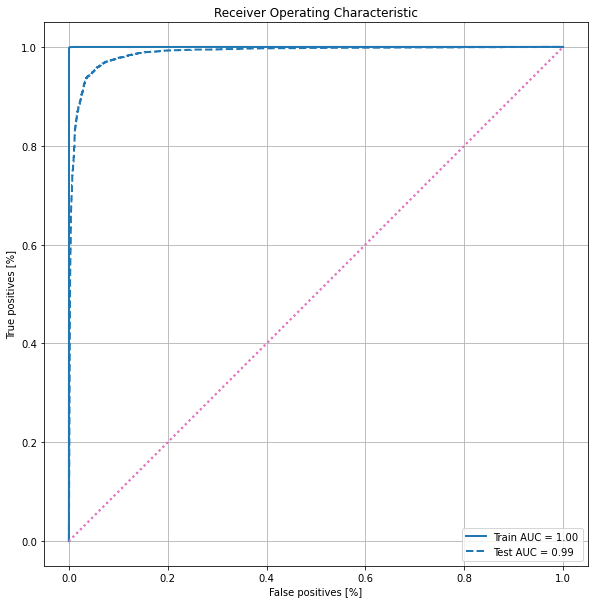

In [40]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

***
**Weights drawn from normal distributions with variances**
***

In [41]:
model = make_model(kernel_initializer=initializers.VarianceScaling(
                    scale=2.0, mode='fan_in', distribution='normal', seed=10
                    ))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12498, 16)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 99952)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 99952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [42]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/20
855/855 [==============================] - 1061s 1s/step - loss: 0.3088 - tp: 19292.2161 - fp: 1846.5818 - tn: 18261.9813 - fn: 1700.1133 - accuracy: 0.9137 - precision: 0.9119 - recall: 0.9200 - auc: 0.9635 - val_loss: 0.1827 - val_tp: 6655.0000 - val_fp: 595.0000 - val_tn: 6082.0000 - val_fn: 345.0000 - val_accuracy: 0.9313 - val_precision: 0.9179 - val_recall: 0.9507 - val_auc: 0.9798
Epoch 2/20
855/855 [==============================] - 1065s 1s/step - loss: 0.1410 - tp: 13288.4206 - fp: 725.7558 - tn: 12684.0946 - fn: 725.6215 - accuracy: 0.9480 - precision: 0.9491 - recall: 0.9493 - auc: 0.9874 - val_loss: 0.1677 - val_tp: 6667.0000 - val_fp: 523.0000 - val_tn: 6154.0000 - val_fn: 333.0000 - val_accuracy: 0.9374 - val_precision: 0.9273 - val_recall: 0.9524 - val_auc: 0.9824
Epoch 3/20
855/855 [==============================] - 1061s 1s/step - loss: 0.1054 - tp: 13596.9217 - fp: 515.9463 - tn: 12771.9287 - fn: 539.0958 - accuracy: 0.9626 - precision: 0.9647 - recall: 0.

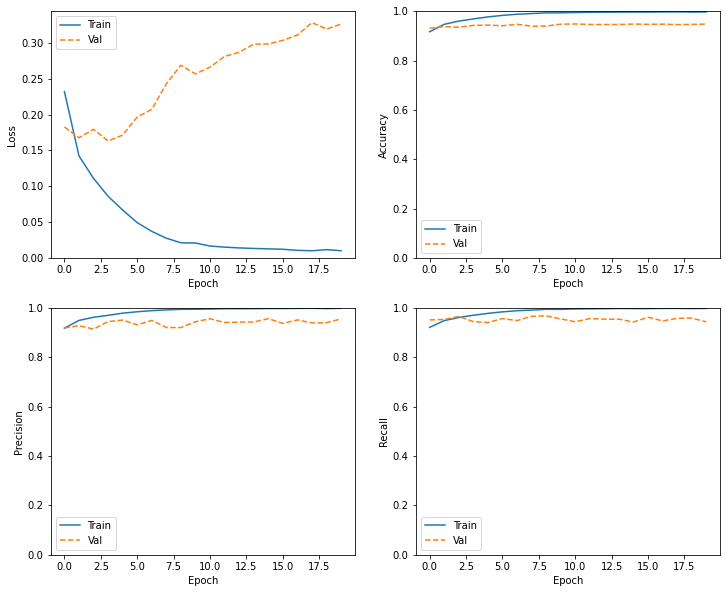

In [43]:
plot_metrics(history)

In [44]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [45]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3570
False Positives:  140
False Negatives:  214
True Positives:  3675


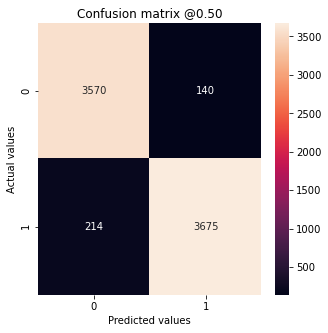

In [46]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [47]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3710
           1       0.96      0.94      0.95      3889

    accuracy                           0.95      7599
   macro avg       0.95      0.95      0.95      7599
weighted avg       0.95      0.95      0.95      7599



In [48]:
f1 = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1)

F1: 0.95


In [49]:
auc = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc)

AUC: 0.99


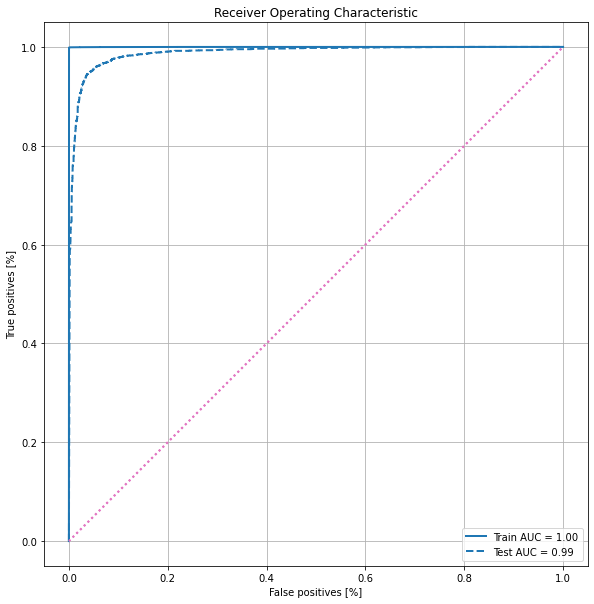

In [50]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

Some approaches incorporate variance scaling directly into the network architecture. This is an active area of research but a simple to use technique that has gained a lot of popularity is batch normalization. The basic idea is to insert extra layers that normalize data after fully-connected and convolutional layers in the network. This optimizes the data flow dynamically, which allows the network to achieve good results with a wider range of initialization strategies. Given that the added layers are compatible with backpropagation, the technique is essentially plug-and-play so the most obvious downside is a small runtime penalty due to the extra layers.